In [1]:
!pip install xgboost==2.1.1
!pip install scikit-learn==1.5.2

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import pickle

# Examining the Data

In [3]:
# Load in the csv file.
data = pd.read_csv('FinancialMarketData.csv')

# Display the first few rows of the data.
print(data.head())

   Y       Date  XAU BGNL  ECSURPUS    BDIY     CRY     DXY     JPY    GBP  \
0  0  1/11/2000    283.25     0.077  1388.0  157.26  100.56  105.86  1.646   
1  0  1/18/2000    287.65     0.043  1405.0  165.01  101.86  105.47  1.638   
2  0  1/25/2000    287.15     0.135  1368.0  167.24  102.41  106.04  1.650   
3  0   2/1/2000    282.75     0.191  1311.0  166.85  104.92  107.85  1.611   
4  1   2/8/2000    298.40     0.312  1277.0  165.43  104.22  109.30  1.611   

     Cl1  ...  LP01TREU  EMUSTRUU  LF94TRUU     MXUS    MXEU     MXJP    MXBR  \
0  25.77  ...   116.464   230.527   123.762  1416.12  127.75   990.59  856.76   
1  28.85  ...   117.267   231.377   123.762  1428.79  129.50   993.98  925.22   
2  28.28  ...   117.995   232.390   123.762  1385.93  126.48   974.83  886.93   
3  28.22  ...   120.510   231.942   122.328  1385.31  129.19  1007.12  842.60   
4  28.02  ...   118.791   237.812   122.328  1411.95  134.67  1034.58  945.15   

     MXRU    MXIN   MXCN  
0  224.33  217.34

In [4]:
# Create a dataframe without the Data column to keep all values numeric.
date_col = data['Date']
df = data.drop('Date', axis=1)

# Store target variable (Y column)
y = df['Y']
X = df.drop('Y', axis=1)

print(df.head())

   Y  XAU BGNL  ECSURPUS    BDIY     CRY     DXY     JPY    GBP    Cl1    VIX  \
0  0    283.25     0.077  1388.0  157.26  100.56  105.86  1.646  25.77  22.50   
1  0    287.65     0.043  1405.0  165.01  101.86  105.47  1.638  28.85  21.50   
2  0    287.15     0.135  1368.0  167.24  102.41  106.04  1.650  28.28  23.02   
3  0    282.75     0.191  1311.0  166.85  104.92  107.85  1.611  28.22  23.45   
4  1    298.40     0.312  1277.0  165.43  104.22  109.30  1.611  28.02  21.25   

   ...  LP01TREU  EMUSTRUU  LF94TRUU     MXUS    MXEU     MXJP    MXBR  \
0  ...   116.464   230.527   123.762  1416.12  127.75   990.59  856.76   
1  ...   117.267   231.377   123.762  1428.79  129.50   993.98  925.22   
2  ...   117.995   232.390   123.762  1385.93  126.48   974.83  886.93   
3  ...   120.510   231.942   122.328  1385.31  129.19  1007.12  842.60   
4  ...   118.791   237.812   122.328  1411.95  134.67  1034.58  945.15   

     MXRU    MXIN   MXCN  
0  224.33  217.34  34.30  
1  234.37  227

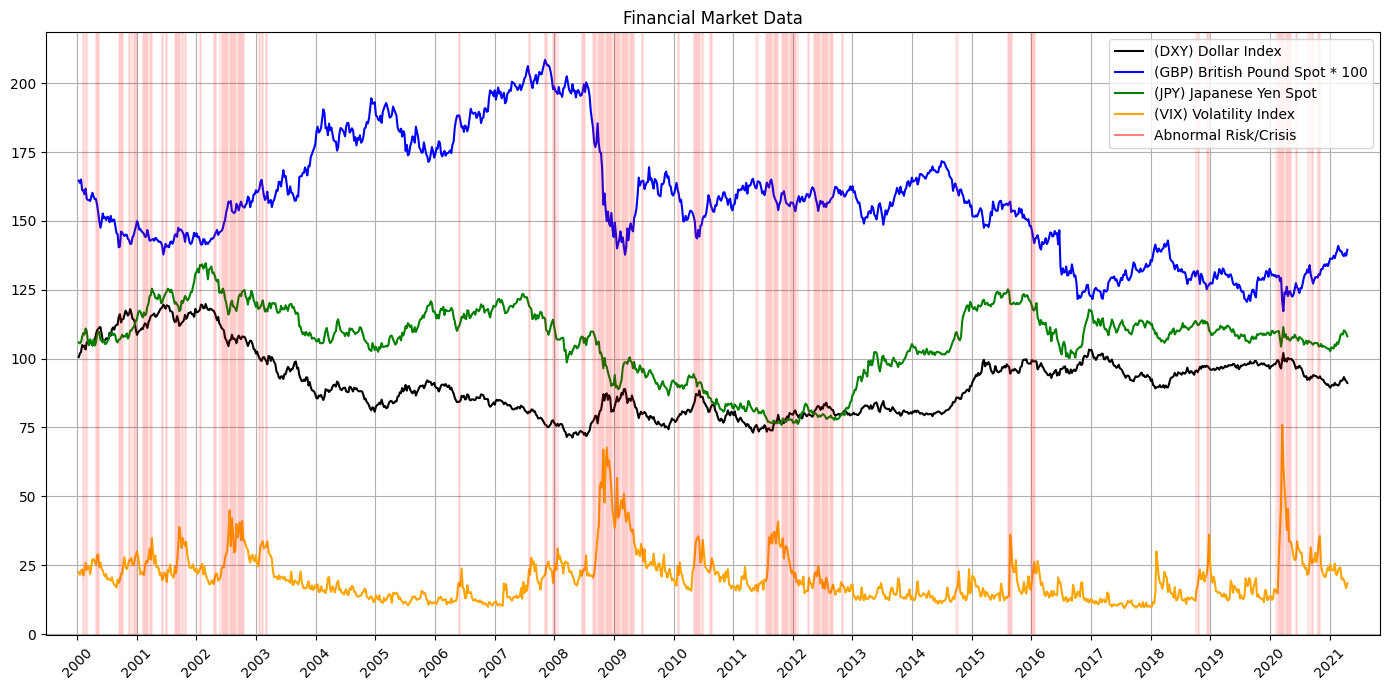

In [5]:
# Create line graph of DXY, GBP, JPY, and VIX values so I can see how they changed
# in relation to one another over time.

import matplotlib.pyplot as plt
from datetime import timedelta

# Convert 'Date' column to datetime objects
data['Date'] = pd.to_datetime(data['Date'])

# Create the plot
plt.figure(figsize=(14, 7))

# Plot 'DXY', 'GBP', and 'JPY'
plt.plot(data['Date'], data['DXY'], color='black', label='(DXY) Dollar Index')
plt.plot(data['Date'], data['GBP'] * 100, color='blue', label='(GBP) British Pound Spot * 100')  # Multiply GBP values by 100
plt.plot(data['Date'], data['JPY'], color='green', label='(JPY) Japanese Yen Spot')
plt.plot(data['Date'], data['VIX'], color='orange', label='(VIX) Volatility Index')
# Dummy plot for red lines in legend
plt.plot([], [], color='red', alpha=0.5, label='Abnormal Risk/Crisis')

# Plot red dots and vertical lines for target values == 1
for index, row in data[data['Y'] == 1].iterrows():
    # plt.plot(row['Date'], row['GBP'] * 100, marker='.', markersize=8, color='red')
    plt.axvline(x=row['Date'], color='red', linestyle='-', alpha=0.1)

# Set x-axis limits to match data range, with some padding
padding = timedelta(days=200)
plt.xlim(data['Date'].min() - padding, data['Date'].max() + padding)

# Customize the plot
# plt.xlabel('Date')
# plt.ylabel('Values')
plt.title('Financial Market Data')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator(1))
plt.show()

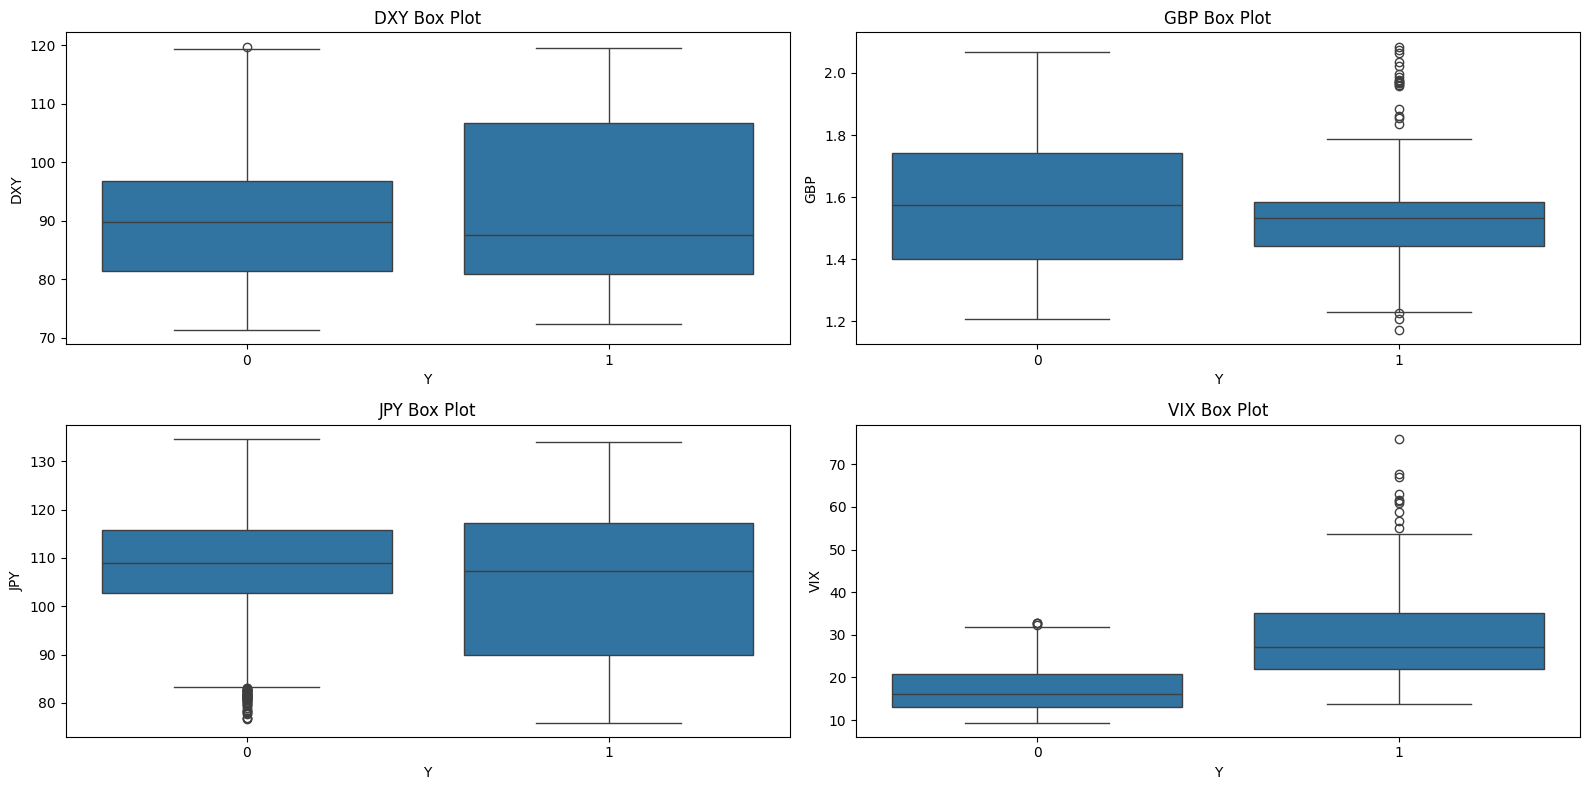

In [6]:
# Generate box plots for each metric

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
sns.boxplot(x='Y', y='DXY', data=df)
plt.title('DXY Box Plot')

plt.subplot(2, 2, 2)
sns.boxplot(x='Y', y='GBP', data=df)
plt.title('GBP Box Plot')

plt.subplot(2, 2, 3)
sns.boxplot(x='Y', y='JPY', data=df)
plt.title('JPY Box Plot')

plt.subplot(2, 2, 4)
sns.boxplot(x='Y', y='VIX', data=df)
plt.title('VIX Box Plot')

plt.tight_layout()
plt.show()

# Model Training

In [7]:
# Split data temporally (not randomly)
def train_test_split_temporal(data, train_size=0.8):
    train_size = int(len(data) * train_size)
    train = data[:train_size]
    test = data[train_size:]
    return train, test

# Scale the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled['Y'] = y  # Add back the target variable

# Split into train and test
train_data, test_data = train_test_split_temporal(X_scaled, train_size=0.8)

In [8]:
## Train and evaluate models to see how they each perform ##

X_train = train_data.drop('Y', axis=1)
y_train = train_data['Y']
X_test = test_data.drop('Y', axis=1)
y_test = test_data['Y']

# Function to evaluate models.
def evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"{model.__class__.__name__} Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

# Train XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

# Train RFC
rf_model = RandomForestClassifier(random_state=42)

# Create an instance of the Bagging model with DecisionTreeClassifier as the base estimator.
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42)

evaluate(xgb_model, X_train, X_test, y_train, y_test)
evaluate(rf_model, X_train, X_test, y_train, y_test)
evaluate(bagging_clf, X_train, X_test, y_train, y_test)

XGBClassifier Accuracy: 0.9283

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       194
           1       1.00      0.45      0.62        29

    accuracy                           0.93       223
   macro avg       0.96      0.72      0.79       223
weighted avg       0.93      0.93      0.92       223

RandomForestClassifier Accuracy: 0.9283

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       194
           1       0.88      0.52      0.65        29

    accuracy                           0.93       223
   macro avg       0.91      0.75      0.81       223
weighted avg       0.93      0.93      0.92       223

BaggingClassifier Accuracy: 0.8969

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       194
           1       0.62      0.55      0.58        29

    

In [9]:
from sklearn.ensemble import VotingClassifier

In [10]:
# Create an ensemble model comprised of three models.
# voting=soft means the classifier will weight the predictions of the individual
# models by their accuracy.
voting_clf_soft = VotingClassifier(
    estimators=[
        ('xgboost', xgb.XGBClassifier(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('bc', BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42))
    ],
    voting="soft"
)

# Create an ensemble model comprised of three models.
# voting=hard means the classifier will simply take the majority vote of the
# individual models.
voting_clf_hard = VotingClassifier(
    estimators=[
        ('xgboost', xgb.XGBClassifier(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('bc', BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42))
    ],
    voting="hard"
)

evaluate(voting_clf_soft, X_train, X_test, y_train, y_test)
evaluate(voting_clf_hard, X_train, X_test, y_train, y_test)

VotingClassifier Accuracy: 0.9327

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       194
           1       0.94      0.52      0.67        29

    accuracy                           0.93       223
   macro avg       0.93      0.76      0.81       223
weighted avg       0.93      0.93      0.92       223

VotingClassifier Accuracy: 0.9283

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       194
           1       0.88      0.52      0.65        29

    accuracy                           0.93       223
   macro avg       0.91      0.75      0.81       223
weighted avg       0.93      0.93      0.92       223



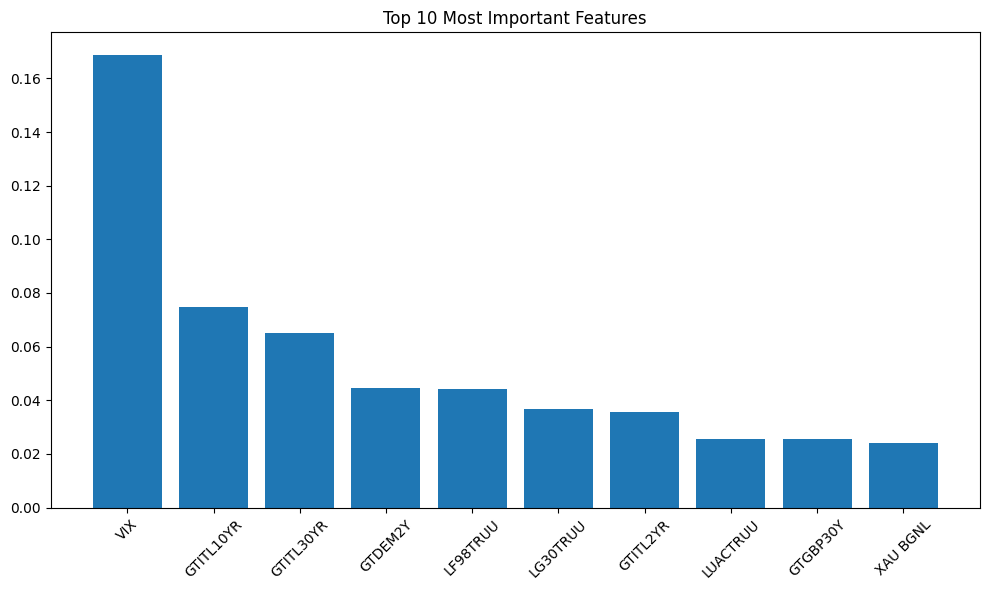

In [11]:
# Visualize Feature Importance for XGBoost
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45)
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

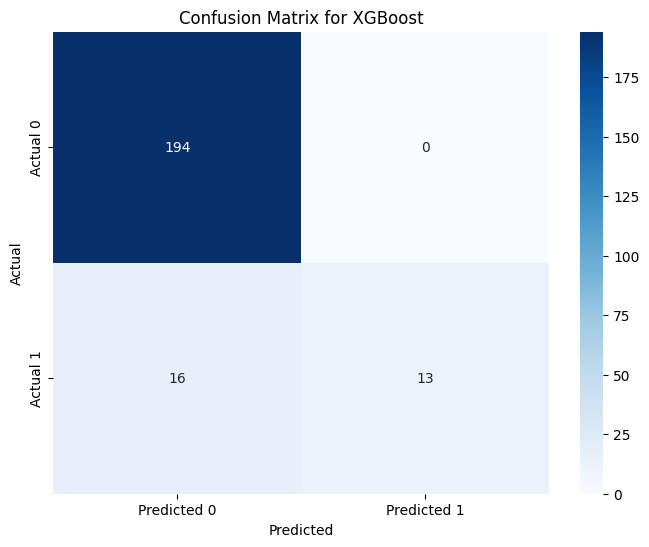

In [12]:
# Display a confusion matrix of XGBoost model's predictions

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

preds = xgb_model.predict(X_test)

cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Using SMOTE to improve Recall for Y=1

In [13]:
from imblearn.over_sampling import SMOTE

In [19]:
# Create an instance of the SMOTE class.
smote = SMOTE(random_state=42)

# Apply SMOTE to our training data to create new synthetic data for the minority
# class.
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

xgb_model_with_SMOTE = xgb.XGBClassifier(random_state=42)

evaluate(xgb_model_with_SMOTE, X_resampled, X_test, y_resampled, y_test)

XGBClassifier Accuracy: 0.9372

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       194
           1       1.00      0.52      0.68        29

    accuracy                           0.94       223
   macro avg       0.97      0.76      0.82       223
weighted avg       0.94      0.94      0.93       223



In [15]:
from collections import Counter

print(f"Original dataset class distribution: {Counter(y_train)}")
print(f"Resampled dataset class distribution: {Counter(y_resampled)}")

Original dataset class distribution: Counter({0: 680, 1: 208})
Resampled dataset class distribution: Counter({0: 680, 1: 680})


In [16]:
# Assign custom values to XGBoost model parameters
xgb_model_with_SMOTE_custom = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=5,
    random_state=42
)

evaluate(xgb_model_with_SMOTE_custom , X_resampled, X_test, y_resampled, y_test)

XGBClassifier Accuracy: 0.9283

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       194
           1       0.78      0.62      0.69        29

    accuracy                           0.93       223
   macro avg       0.86      0.80      0.83       223
weighted avg       0.92      0.93      0.92       223



In [25]:
# Get predicted probabilities for class 1 (market crash)
y_pred_proba = xgb_model_with_SMOTE_custom.predict_proba(X_test)[:, 1]

thresholds = [0.39, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65]
for threshold in thresholds:
    y_pred_new = (y_pred_proba >= threshold).astype(int)
    print(f"Threshold: {threshold}")
    print(classification_report(y_test, y_pred_new))

Threshold: 0.39
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       194
           1       0.45      0.83      0.59        29

    accuracy                           0.85       223
   macro avg       0.71      0.84      0.75       223
weighted avg       0.90      0.85      0.86       223

Threshold: 0.4
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       194
           1       0.51      0.69      0.59        29

    accuracy                           0.87       223
   macro avg       0.73      0.80      0.76       223
weighted avg       0.89      0.87      0.88       223

Threshold: 0.45
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       194
           1       0.61      0.66      0.63        29

    accuracy                           0.90       223
   macro avg       0.78      0.80      0.79       223
weighted avg       0.90    

In [27]:
# Get predicted probabilities for class 1 (market crash)
y_pred_proba = xgb_model_with_SMOTE.predict_proba(X_test)[:, 1]

thresholds = [0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.03]
for threshold in thresholds:
    y_pred_new = (y_pred_proba >= threshold).astype(int)
    print(f"Threshold: {threshold}")
    print(classification_report(y_test, y_pred_new))

Threshold: 0.013
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       194
           1       0.44      0.83      0.57        29

    accuracy                           0.84       223
   macro avg       0.70      0.83      0.74       223
weighted avg       0.90      0.84      0.86       223

Threshold: 0.014
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       194
           1       0.45      0.79      0.57        29

    accuracy                           0.85       223
   macro avg       0.71      0.82      0.74       223
weighted avg       0.90      0.85      0.86       223

Threshold: 0.015
              precision    recall  f1-score   support

           0       0.97      0.86      0.91       194
           1       0.46      0.79      0.58        29

    accuracy                           0.85       223
   macro avg       0.71      0.83      0.75       223
weighted avg       0.90

In [28]:
# Use pickle to save the model.  "wb" means open the file in binary mode.
with open("xgb_model_with_SMOTE_018", "wb") as file:
    pickle.dump(xgb_model_with_SMOTE, file)

print(f"Model saved.")


Model saved.
